In [1]:
%reset

In [2]:
import pandas as pd
import numpy as np
import json
from sentence_transformers import SentenceTransformer

In [3]:
business_data = json.load(open("yelp_dataset/yelp_filtered_philadelphia_business.json"))

# Create a DataFrame for business data
business_df = pd.DataFrame(business_data)

# Flatten the nested "attributes" column
business_attributes = pd.json_normalize(business_df['attributes'])
business_attributes.columns = [f'attributes.{col}' for col in business_attributes.columns]

business_hours = pd.json_normalize(business_df['hours'])
business_hours.columns = [f'WorkingHours.{col}' for col in business_hours.columns]


# Concatenate the flattened attributes DataFrame with the original business DataFrame
business_df = pd.concat([business_df, business_attributes], axis=1)
business_df = pd.concat([business_df, business_hours], axis=1)

# Drop the original nested "attributes" column
business_df = business_df.drop('attributes', axis=1)
business_df = business_df.drop('hours', axis=1)

In [4]:
review_data = json.load(open("yelp_dataset/yelp_filtered_philadelphia_reviews.json"))
review_df = pd.DataFrame(review_data)

### Each review is unique

In [5]:
review_df["review_id"].duplicated().sum()

0

In [6]:
business_df["is_open"].value_counts()

1    4372
0    2704
Name: is_open, dtype: int64

### Filter permanently closed businesses

In [7]:
business_df = business_df[business_df["is_open"] == 1]

In [8]:
business_df.drop(columns=["city", "state", "latitude", "longitude", "is_open"], inplace=True)
review_df.drop(columns=["user_id", "date"], inplace=True)

### Filter reviews for businesses that are still open

In [9]:
review_df = review_df[review_df["business_id"].isin(business_df["business_id"])]

### Fill closed days

In [10]:
# Fill "closed" if not all columns are empty
def fill_closed(row):
    if row.isnull().all():
        return row
    else:
        return row.fillna("closed")

# Selecting only the columns related to working hours
working_hours_columns = [f'WorkingHours.{day}' for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]

# Applying the custom function to the selected columns
business_df[working_hours_columns] = business_df[working_hours_columns].apply(fill_closed, axis=1)


In [11]:
print(f"Number of rows: {business_df.shape[0]}")
business_df.isna().sum()

Number of rows: 4372


business_id                                 0
name                                        0
address                                     0
postal_code                                 0
stars                                       0
review_count                                0
categories                                  0
attributes.RestaurantsDelivery            559
attributes.OutdoorSeating                1380
attributes.BusinessAcceptsCreditCards     524
attributes.BusinessParking                640
attributes.BikeParking                   1218
attributes.RestaurantsPriceRange2         859
attributes.RestaurantsTakeOut             368
attributes.ByAppointmentOnly             4021
attributes.WiFi                          1498
attributes.Alcohol                       1703
attributes.Caters                        1621
attributes.RestaurantsReservations       1564
attributes.RestaurantsGoodForGroups      1753
attributes.RestaurantsAttire             1983
attributes.HasTV                  

4.0    1139
4.5     859
3.5     853
3.0     552
2.5     374
2.0     251
5.0     197
1.5     117
1.0      30
Name: stars, dtype: int64


<Axes: >

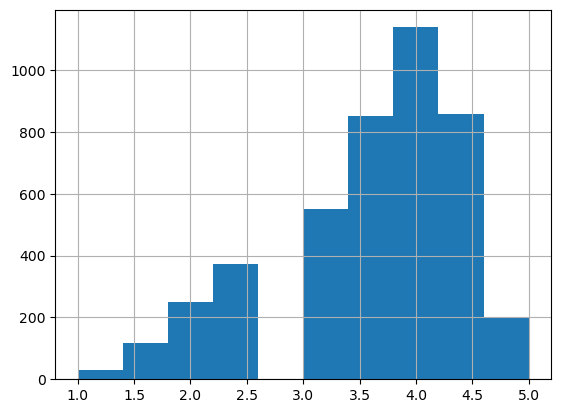

In [12]:
print(business_df["stars"].value_counts())
business_df["stars"].hist()

### Filter businesses with less than 20 reviews and less than 3 stars

In [13]:
high_score = business_df[business_df["stars"] >= 3.0]
high_score = high_score[high_score["review_count"] >= 20]
high_score_reviews = review_df[review_df["business_id"].isin(high_score["business_id"])]

In [14]:
print(f"Number of rows: {high_score.shape[0]}")
high_score.isna().sum()

Number of rows: 2510


business_id                                 0
name                                        0
address                                     0
postal_code                                 0
stars                                       0
review_count                                0
categories                                  0
attributes.RestaurantsDelivery            132
attributes.OutdoorSeating                 416
attributes.BusinessAcceptsCreditCards     110
attributes.BusinessParking                111
attributes.BikeParking                    362
attributes.RestaurantsPriceRange2         284
attributes.RestaurantsTakeOut              61
attributes.ByAppointmentOnly             2223
attributes.WiFi                           464
attributes.Alcohol                        581
attributes.Caters                         499
attributes.RestaurantsReservations        568
attributes.RestaurantsGoodForGroups       680
attributes.RestaurantsAttire              817
attributes.HasTV                  

In [15]:
high_score["attributes.RestaurantsPriceRange2"].fillna("None").value_counts()

2       1272
1        837
None     285
3         99
4         17
Name: attributes.RestaurantsPriceRange2, dtype: int64

5    225778
4    144178
3     62478
1     37992
2     36018
Name: stars, dtype: int64


<Axes: >

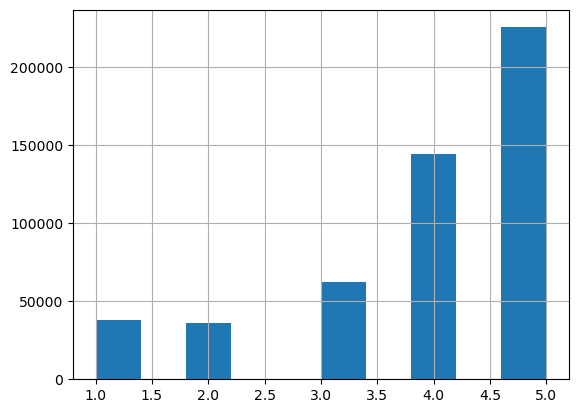

In [16]:
print(high_score_reviews["stars"].value_counts())
high_score_reviews["stars"].hist()

In [17]:
high_score_reviews["business_id"].value_counts()

ytynqOUb3hjKeJfRj5Tshw    5778
PP3BBaVxZLcJU54uP_wL6Q    4293
9PZxjhTIU7OgPIzuGi89Ew    3264
ctHjyadbDQAtUFfkcAFEHw    3173
6ajnOk0GcY9xbb5Ocaw8Gw    2974
                          ... 
NXwEDLZjv8dUqbc5g5dCYg      20
BdWmI-F_7ajVToqDDL5A4A      20
Q_pHfuSpVEIVfjJLUSTu3g      20
vIT19IkXjNd39r55YTeq2w      20
5Orn19gUeqCgKu5IRYlvpQ      20
Name: business_id, Length: 2510, dtype: int64

In [18]:
review_lengths = [len(rev.split(" ")) for _, rev in high_score_reviews["text"].iteritems()]
total_length = sum(review_lengths)

/var/folders/g3/b2rhcsbj74b0r5p3cjff117h0000gn/T/ipykernel_10988/1024516852.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  review_lengths = [len(rev.split(" ")) for _, rev in high_score_reviews["text"].iteritems()]


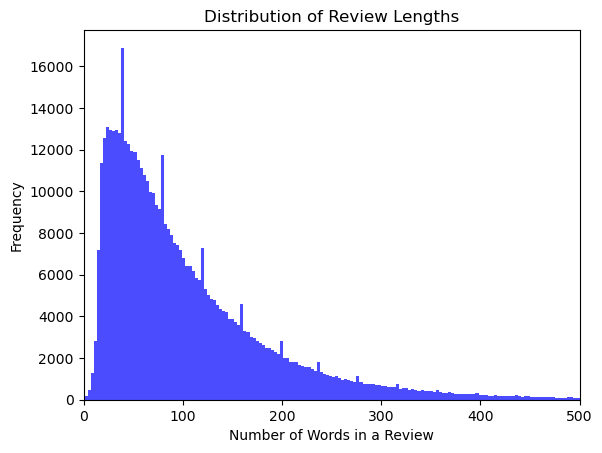

In [19]:
import matplotlib.pyplot as plt

# Plotting the distribution with x-axis limit set to 500
plt.hist(review_lengths, bins=1000, color='blue', alpha=0.7)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words in a Review')
plt.ylabel('Frequency')
plt.xlim(0, 500)  # Set x-axis limit to 500
plt.show()


In [20]:
print(f"Average review length: {total_length / len(review_lengths)}")

Average review length: 107.45317744903682


### Sample 300 reviews per business

In [21]:
# Set the number of reviews you want to draw per business_id
DRAW_CHUNK = 300

# Create an empty DataFrame to store the sampled reviews
sampled_reviews_df = pd.DataFrame()

# Iterate over each business_id and sample reviews
for business_id, group in high_score_reviews.groupby("business_id"):
    # If the business has fewer than 300 reviews, select all of them
    if len(group) <= DRAW_CHUNK:
        sampled_reviews_df = pd.concat([sampled_reviews_df, group])
    else:
        # Randomly sample 300 reviews
        sampled_reviews_df = pd.concat([sampled_reviews_df, group.sample(DRAW_CHUNK, random_state=42)])


In [22]:
sampled_reviews_df["business_id"].value_counts()

-0TffRSXXIlBYVbb5AwfTg    300
VP8HMhVt-pKmqGNmDW4-TQ    300
U30ggGzFpXvc2NZYwOW3qg    300
UQZ4p6xb_7gY7UXHmBzceg    300
UdcLHHBRIxtelgbKBnhitA    300
                         ... 
jsL0EmA3k75npcRvleq2VA     20
NXwEDLZjv8dUqbc5g5dCYg     20
Q_pHfuSpVEIVfjJLUSTu3g     20
PXWYIvRGnAcxWyPwvXbuDw     20
yHsG1SuEtB_pTZ9TjvOxrg     20
Name: business_id, Length: 2510, dtype: int64

In [23]:
review_lengths = [len(text.split(" ")) for _, text in sampled_reviews_df["text"].items()]
total_length = sum(review_lengths)
print(f"Total token length: {total_length}",
      f"Average review length: {total_length / len(review_lengths)}", sep="\n")

Total token length: 34698806
Average review length: 104.11776214123896


### Perform sentence embedding

In [24]:
model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name)

# all_reviews = sampled_reviews_df["text"].tolist()                             
# embeddings = model.encode(all_reviews, show_progress_bar=True)
# np_embeddings = np.array(embeddings)

### Load the embeddings

In [25]:
np_embeddings = np.load("embeddings.npy")

In [26]:
embedding_df = pd.DataFrame({"np_embeddings": np_embeddings.tolist()})
embedding_df.head()

,np_embeddings
0,"[-0.041251879185438156, -0.02629106678068638, ..."
1,"[-0.01969466358423233, -0.029596231877803802, ..."
2,"[0.00347039382904768, 0.053050242364406586, -0..."
3,"[-0.06172171235084534, 0.05515433847904205, -0..."
4,"[-0.04898210987448692, 0.02106931433081627, -0..."


In [27]:
sampled_reviews_df.reset_index(drop=True, inplace=True)
sampled_reviews_df = pd.concat([sampled_reviews_df, embedding_df], axis=1)

In [195]:
sampled_reviews_df["business_id"].unique()

array(['-0TffRSXXIlBYVbb5AwfTg', '-1B9pP_CrRBJYPICE5WbRA',
       '-5Rah4ZvWsDu4oilUZxhtw', ..., 'zwd4dyQ5ovnjVojWfAuhMw',
       'zxRmQ_FWVowh8rlzLCSURQ', 'zz3E7kmJI2r2JseE6LAnrw'], dtype=object)

In [ ]:
import elasticsearch
from elasticsearch import Elasticsearch
from elasticsearch import helpers

class Tokenizer(object):
    def __init__(self):
        self.model = SentenceTransformer("all-mpnet-base-v2")

    def get_token(self, documents):
        sentences  = [documents]
        sentence_embeddings = self.model.encode(sentences)
        _ = list(sentence_embeddings.flatten())
        encod_np_array = np.array(_)
        encod_list = encod_np_array.tolist()
        return encod_list
    
class ElasticSearchImports(object):
    def __init__(self, df, index_name='posting'):
        self.df = df
        self.index_name = index_name
        self.es = Elasticsearch(timeout=30,hosts="http://localhost:9200")

    def run(self):

        elk_data = self.df.to_dict("records")

        for job in elk_data:
            try:self.es.index(index=self.index_name,body=job)
            except Exception as e:pass

        return True

helper_elk = ElasticSearchImports(df=sampled_reviews_df)
helper_elk.run()

/var/folders/g3/b2rhcsbj74b0r5p3cjff117h0000gn/T/ipykernel_10988/2939611013.py:21: DeprecationWarning: The 'timeout' parameter is deprecated in favor of 'request_timeout'
  self.es = Elasticsearch(timeout=30,hosts="http://localhost:9200")


In [ ]:

helper_token = Tokenizer()
INPUT = input("Enter the Input Query ")
token_vector = helper_token.get_token(INPUT)

query ={

    "size":50,
    "_source": "Title",
    "query":{
        "bool":{
            "must":[
                {
                    "knn":{
                        "vectors":{
                            "vector":token_vector,
                            "k":20
                        }
                    }
                }
            ]
        }
    }
}
es = Elasticsearch(timeout=600, hosts="http://localhost:9200")
res = es.search(index='posting',
                size=50,
                body=query,
                request_timeout=55)

title = [x['_source']  for x in res['hits']['hits']]
title